# Machine Learning (CMP3751M/CMP9772M) - Assessment 02

Through the following notebook, you will be analysing a dataset and fitting a classification model to this dataset.

The assessment is structured as follows:
- [Dataset description](#Dataset-description)
- [Loading the dataset](#Loading-the-dataset)
- [Simple classification model](#Simple-classification-model)
    - [Creating a training and testing set](#Creating-a-training-and-testing-set)
    - [Training a classifier](#Training-a-classifier)
- [Improved evaluation strategy](#Improved-evaluation-strategy)
- [Different models and parameter search](#Different-models-and-parameter-search)
- [Ensembles](#Ensembles)
- [Final model evaluation](#Final-model-evaluation)
- [References](#References)

**Notes:**
- The (%) noted above are out of 100; this will be scaled down to **maximum of 60 marks** for the assessment **(or maximum of 50 marks for CMP9772M)** .
- Any discussion not supported by your implementation will not be awarded marks.
- **Do not modify** and code provided as a **TESTING CELL**.
- Make sure to **fix all the random seeds** in any parts of your solution, so it can be reproduced exactly.
- The notebook, as provided, runs without errors (without solving the assessment). Make sure that the solution, or the partial solution, you hand in, also **runs without errors** on the data provided. If you have a partial solution causing errors which you would like to show, please include it as a comment.
- Take care to include references to any external sources used. Check the [References](#References) section, the below cell, and the exambles through the assessment text for examples of how to do this.


In [1]:
# Remember to reference your sources! Check the bottom of the file, and examples used in the text of the assessment,
# for including references to papers and software in your textual answers

# Also add a reference in your solution cell before defining a class/function/method, eg.:

# This code is a modified and extended version of [2]
# OR
# This code is a modified and extended version of https://stackoverflow.com/q/522563/884412
##############
## THE CODE ##
##############

## Dataset description

The the assessment will be done on the dataset containing only numerical features describing the physical and chemical properties of the Li-ion battery, which can be classified on the basis of their crystal system [1]. (The dataset for this assessment has been adapted from the full dataset which can be found [here](https://www.kaggle.com/datasets/divyansh22/crystal-system-properties-for-liion-batteries), shared in the public domain by Divyansh Agrawal).

Each sample corresponds to the properties of a battery, and consists of following features:

| Feature Name      | Value | Description |
| :---------------- | :----- | ----------- |
| `Formation Energy`       | `float`: eV | Formation energy of the material. |
| `E Above Hull` | `float`: eV | Energy of decomposition of material into most stable ones. |
| `Band Gap` | `float`: eV | Band gap. |
| `Nsites` | `int`: count | Number of atoms in the unit cell of the crystal. |
| `Density` | `float`: gm/cc | The density of bulk crystalline materials. |
| `Volume` | `float` | The unit cell volume of the material. |

The goal for the assessment is to predict whether the crystal system of the battery is _monoclinic_, _orthorhombic_ or _triclinic_, which provides a classification for each sample:

| Class      | Value | Description |
| :---------------- | :----- | ----------- |
| `Crystal System`  | `string`: class designation | Class of the crystal system. |


## Loading the dataset

The dataset is given in _batteries.csv_ file provided on Blackboard. **Load the dataset into two [`numpy.array`](https://numpy.org/doc/stable/reference/generated/numpy.array.html)s.**: 
- The variable `X` should be a 2D [`numpy.array`](https://numpy.org/doc/stable/reference/generated/numpy.array.html) containing all the samples and their features from the dataset, one sample per row. 
- The variable `y` should be a 1D [`numpy.array`](https://numpy.org/doc/stable/reference/generated/numpy.array.html) containing the ground truth (class) as given in the `'Crystal System'` field of the _.csv_ file.
- _Note_: The class in the `'Crystal System'` column is given as a string. Make sure you encode the class as an integer number in your ground truth `y`.
- _Note_: You should make sure that your code for loading the dataset is guided by the information about the dataset, and the dataset description you provide as your answer.

**Describe the dataset**. Provide a basic description of the dataset. How many samples are there in the dataset? How many distinct classes? What types of features describe the samples in the dataset? Are there any missing values in the dataset? (Make sure these are properly handled). 
- _Note_: Make sure all your answers are supported by your implementation. Answers not supported by your implementation will not score any marks.

Provide your code to _load the dataset_ and the code that will allow you to _describe the dataset_ in the **SOLUTION CELL**. Provide your description of the dataset in the **ANSWER CELL**. A correct solution should result in no errors when running the **TESTING CELL** provided.

**SOLUTION CELL**

1. The dataset contains 339 samples and 7 features.

2. The dataset has 3 distinct classes.

3. The features consist of Formation Energy, E Above Hull, Band Gap, Nsites, Density, Volume.

4. The features are of type:
Formation Energy    float64
E Above Hull        float64
Band Gap            float64
Nsites                int64
Density             float64
Volume              float64
Crystal System       object
dtype: object

5. Columns containing missing values (with count):
Formation Energy    1
E Above Hull        0
Band Gap            2
Nsites              0
Density             2
Volume              0
Crystal System      0
dtype: int64


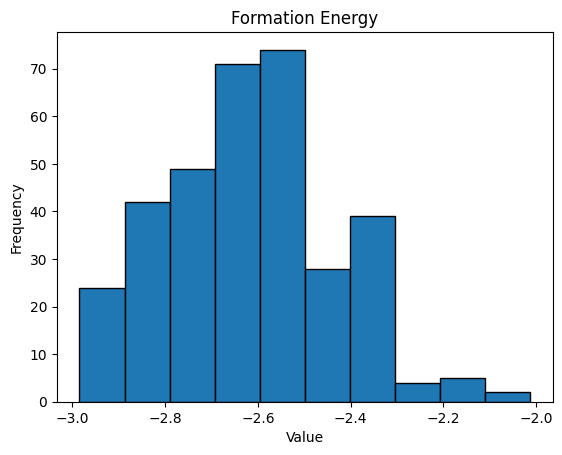

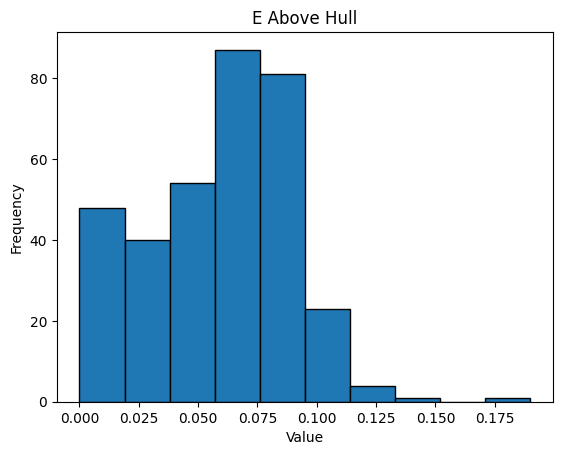

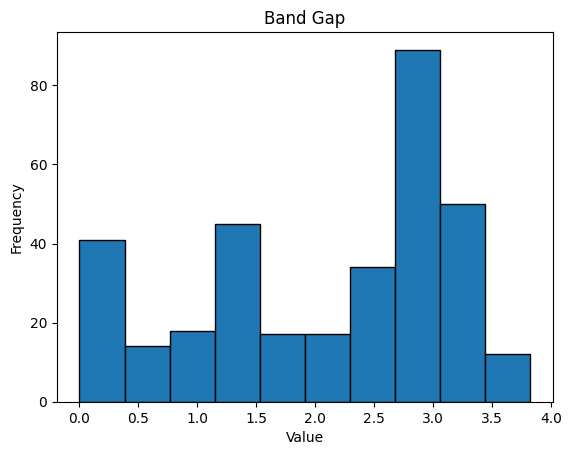

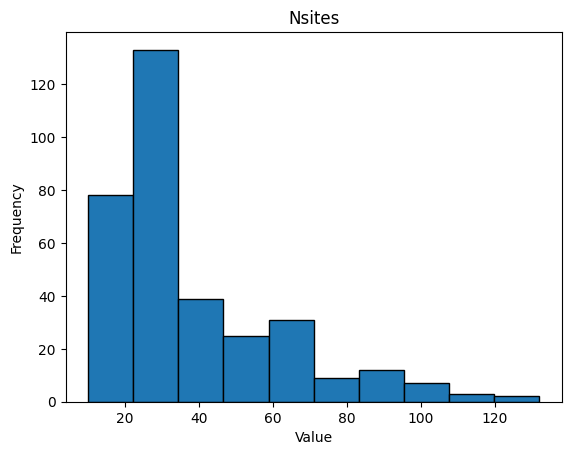

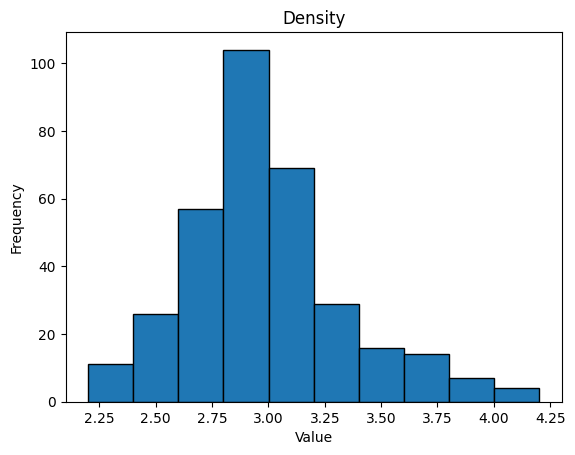

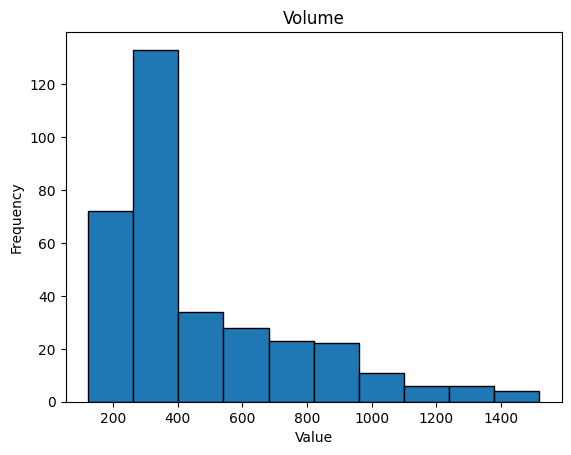

Outliers from IQR method (Formation Energy):  []
Outliers from IQR method (E Above Hull):  [0.19]
Outliers from IQR method (Band Gap):  [0.19]
Outliers from IQR method (Nsites):  [0.19, 92, 92, 92, 96, 100, 100, 100, 100, 100, 100, 112, 112, 112, 128, 132]
Outliers from IQR method (Density):  [0.19, 92, 92, 92, 96, 100, 100, 100, 100, 100, 100, 112, 112, 112, 128, 132]
Outliers from IQR method (Volume):  [0.19, 92, 92, 92, 96, 100, 100, 100, 100, 100, 100, 112, 112, 112, 128, 132, 1074.67, 1077.384, 1080.318, 1123.305, 1165.318, 1178.251, 1219.453, 1234.971, 1235.941, 1243.201, 1248.278, 1257.0839999999998, 1338.234, 1342.122, 1374.684, 1399.85, 1444.106, 1444.706, 1518.85]


In [2]:
import numpy as np
import pandas as pd

################################
#### ADD YOUR SOLUTION HERE ####
################################

# Load the battery.csv data set into a pandas DataFrame
df = pd.read_csv('batteries.csv')

# Describe data set
print(f"1. The dataset contains {df.shape[0]} samples and {df.shape[1]} features.\n")
print(f"2. The dataset has {len(df['Crystal System'].unique())} distinct classes.\n")
print(f"3. The features consist of {', '.join(df.columns[:-1])}.\n")
print(f"4. The features are of type:\n{df.dtypes}\n")
print(f"5. Columns containing missing values (with count):\n{df.isnull().sum()}")

# Define a mapping of categorical values to numeric values for the ground truths
class_mapping = {'monoclinic':0, 'orthorhombic':1, 'triclinic':2}

# Replace the categorical variables with the numeric ones
df['Crystal System'] = df['Crystal System'].replace(class_mapping)

# Load all samples and their features from the data frame into variable X
X = df.loc[:, df.columns!='Crystal System'].values

# Load the ground truth labels from the data frame into variable y
y = df["Crystal System"].values

# Handle missing values using simple inputer
from sklearn.impute import SimpleImputer

# Create an instance of the SimpleImputer class
imputer = SimpleImputer(strategy='mean')

# Fit the imputer to the dataset
imputer.fit(X)

# Transform the dataset using the imputer
X = imputer.transform(X)

# Create a histogram for each feature (as there is not a vast amount of features) 
# to see if our data is normally distributed, if it is we can use z score to spot outliers,
# if not we can use IQR to find outliers
import matplotlib.pyplot as plt

for column in df.iloc[:,:-1]:
    plt.hist(df[column], edgecolor='black')
    plt.title(column)
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.show()

# Find outliers in data using IQR as we found upon inspection that the data is not normally distributed
outliers = []
def detect_outliers_iqr(data):
    data = sorted(data)
    q1 = np.percentile(data, 25)
    q3 = np.percentile(data, 75)

    # Calculate Inter quartile range
    IQR = q3-q1
    lwr_bound = q1-(1.5*IQR)
    upr_bound = q3+(1.5*IQR)

    # Loop through the data and check if the value is an outlier
    for i in data: 
        if (i<lwr_bound or i>upr_bound):
            outliers.append(i)
            
    return outliers

# Pass each df features columns 1 by 1 and see the potential outliers (expect the last column as it is the ground truth)
for column in df.iloc[:,:-1]:
    sample_outliers = detect_outliers_iqr(df[column])
    print(f"Outliers from IQR method ({column}): ", sample_outliers)

# Maybe mention we could just keep the potential outliers as we simply dont know enough baout the dataset in depth to remove the values
# They could provide some vlauble insights of the data mentions what is says in the lectures about outliers.
# Also double check with last years assignment if they did anything with outliers and if they have the samne outliers found abovw
# https://www.freecodecamp.org/news/how-to-detect-outliers-in-machine-learning/ use this and reference in discussion of outliers and 
# the method we used
# Note there is 21 0 values in the dataset, maybe mention this as well
# CREATE A boxplot for each feature and see if it aligns with the IQR method AND the histogram

**TESTING CELL**

In [3]:
assert(len(X.shape) == 2)
assert(len(y.shape) == 1)
assert(X.shape[0] == y.shape[0])

**ANSWER CELL**

_Write your answer here._

## Simple classification model

To get the feel for the dataset, the first step will be to build train a simple classification model for this dataset. Do this in two steps detailed below:
1. Set aside some data for training and for testing.
2. Train a simple classifier on this data.

### Creating a training and testing set

**Set aside 20\% of the data for testing, and use the remaining 80\% to train your model.** Make sure to fix any random seeds if you use any functions or methods relying on those, so your experiments are _fully repeatable_. Initialise the following variables:
- `X_train` should contain the features corresponding to your training data.
- `y_train` should contain the ground truth of your training data.
- `X_test` should contain the features corresponding to your testing data.
- `y_train` should contain the ground truth associated to your testing data.

_Note:_ No additional marks will be rewarded for implementing an advanced data splitting strategy on this task. The purpose of this task is to start working with the dataset by applying a simple approach; you will have the chance to implement more complex evaluation pipelines in a later task.

Provide your implementation in the **SOLUTION CELL (a)** below. A correct solution should result in no errors when running the **TESTING CELL** provided.

### Training a classifier

**Train a simple classifier,** (of your choosing) **with fixed parameters** on the dataset, and **calculate accuracy on the test set**.
- Define a function `model_accuracy(y_test, y_pred)` to compare the ground truth given in `y_test` to predictions given in `y_pred` and calculate accuracy.
- **Store the model** in the variable named `model`. For the model, you may chose any classifier with which you are familiar (e.g. K Nearest Neighbours), or implement your own classifier. Make sure you **train your model** using the _training data_ only (`X_train`, `y_train`).
- Use the model to **predict the classes of the data** in the testing set (`X_test`), and calculate the accuracy by comparing the predictions with the ground truth for the testing set (`y_test`). **Store the predictions** in a variable called `y_test`.

_Note:_ Do not implement an advanced strategy to chose the parameters of your classifier here, as that will be a topic of a latter question.

_Note:_ If you implement your own classifier, make sure you implement it as a _class_ following the _sklearn_ standard for classifiers (i.e. make sure it implements the `fit(X, y)` method to train the model, and `predict(X)` method to use the trained model to predict the classes of provided samples.


**Discuss the advantages and shortcomings** of the evaluation strategy implemented through this task. Discuss both the data split used for evaluation and the choice of metric. Taking into account the information you know about the dataset, what kind of accuracy scores can you expect on this dataset from a good and bad performing model? Based on the information you have so far, comment on the performance of the model you have trained on the provided dataset.

Provide your implementation in the **SOLUTION CELL (b)** below. The **TESTING CELL** below should run without errors and will print the prediction of your model for the first sample in the test set, and the accuracy as calculated by your `model_accuracy` function. Provide your discussion in the **ANSWER CELL** below.

**SOLUTION CELL (a)**

In [4]:
from sklearn.model_selection import train_test_split

################################
#### ADD YOUR SOLUTION HERE ####
################################

# Split the data set into a training set and a test set 80 % / 20 %
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)


**TESTING CELL**

In [5]:
assert(X_train.shape[0] == y_train.shape[0])
assert(X_test.shape[0] == y_test.shape[0])
assert(X_train.shape[1] == X_test.shape[1])

**SOLUTION CELL (b)**

In [6]:
def model_accuracy(y_test, y_pred):
    # Check that the input lists are of the same length
    assert(len(y_test) == len(y_pred))
    
    # Calculate the accuracy of the model
    accuracy = np.sum(y_test == y_pred) / len(y_test)
    
    return accuracy

################################
#### ADD YOUR SOLUTION HERE ####
################################
from sklearn.neighbors import KNeighborsClassifier

# Create a KNN classifier with 3 neighbors
model = KNeighborsClassifier(n_neighbors=3)
    
# Fit the model to the training data
model.fit(X_train, y_train)

# Predict the labels for the test data
y_predictions = model.predict(X_test)


**TESTING CELL**

In [7]:
print(model.predict(X_test[0].reshape(1,-1)))
print(model_accuracy(y_test, y_predictions))

[0]
0.5147058823529411


**ANSWER CELL**

The evaluation method performed was accuracy. "It is a common metric used to measure the overall
correctness of model’s predictions; it quantifies the ratio of correctly predicted instances to the total number of instances in the dataset". 
REFERENCE SLIDE 9 WEEK 2 <------


The accuracy evaluation strategy implemented through this task has some advantages and shortcomings. One advantage is that it provides a simple and straightforward way to evaluate the performance of a classifier on both the train and test data. However, there are also some shortcomings to this evaluation strategy.One shortcoming is for example, if the classes are imbalanced, accuracy may be misleading, as a classifier that always predicts the majority class will have a high accuracy but may not be useful in practice. Moreover, the choice of metric may not always be appropriate for the problem at hand. For example, in some cases, precision or recall may be more appropriate metrics to use.

An 80% / 20% training/test data split is common in machine learning tasks. However, one significant drawback is that the performance of the models can be highly dependent on the specific split of the data. For instance datasets with some infrequent classes or outliers then fitting the model to the data may produce unwanted results. A better evaluation strategy is k-fold cross validation.
"This is a widely used technique in machine learning and statistical modeling to assess the performance and generalization of a model. It helps in estimating how well a model will perform
on unseen data, which is crucial for avoiding either overfitting or underfitting".
REFERENCE SLIDE 21 WEEK 2 <------


We can also utilize the use of leave-one-out cross validation (LOOCV). In leave-one-out cross validation, instead of using k folds, the data is used to train the model one time for each item in the set, using all other items as a training set and only one item as the testing set. This will give a model performance metric which is more robust to outliers in the data. However due to our model having a fair few samples this may not be the best approach to take, as LOOCV can be computationally expensive and time consuming.

Trying to construct a good / bad accuracy score we can get from the model depends on several factors such as the complexity of the problem, the quality of the data, and the choice of classification algorithm. Based on the structure of the dataset, the dataset having 6 features (independent variables), 3 possible classes (dependent variables) and 339 samples, we can expect a good performing model to achieve an accuracy score of around 80% or higher, while a bad performing model would achieve an accuracy score of around 50% or lower (essentially being 50% or lower is saying the model is worse then simply just guessing). Based on the information we have so far, the model we have trained on the provided dataset achieved an accuracy score of 51%. This suggests that the model may not be complex enough to capture the underlying patterns in the data. It is possible that a more complex model or a different classification algorithm may perform better on this dataset. However, it is also important to keep in mind that this is just a preliminary evaluation, and further optimization such as hyperparameter tuning may be possible.

## Improved evaluation strategy

After discussing the shortcomings of the simple evaluation strategy used in the previous task, you now have a chance to **propose a better evaluation strategy.** Make sure your chosen strategy **uses all the samples in the dataset** to report the result.
- Implement a function `evaluate_model(model, X, y)` to implement your proposed evaluation strategy. The function should evaluate the model given in `model` on the dataset given by `X` with ground truth given by `y`. Note that the function should be passed the _whole of the dataset_ (see **TESTING CELL** below) and should take care of any data splitting internally.
- If desired, you may add additional arguments to this function, as long as they have default values and the function runs correctly when called using those default values.
- The function should return no values, but instead print the results of the evaluation in a human-readable format.
- Include at least one summative metric (providing a single number, e.g. accuracy) and per-class metric (e.g. precision). You are encouraged to select more than one metric of each type.

This function will be used to provide a better evaluation of the simple model with fixed parameters used in the previous task.

**Discuss your chosen evaluation strategy**, including both the data split and the evaluation metrics. Which data splitting strategy did you chose and why? Which metrics did you chose, and why? Briefly explain the chosen data splitting strategy. What additional information can your additional metrics provide beyond accuracy?

Provide your implementation of this function in the **SOLUTION CELL**. You may also include any additional evaluation calls you want to include in this code cell. The **TESTING CELL** will perform a basic evaluation of your `model` using the `evaluate_model` function implemented for this task. Provide your discussion in the **ANSWER CELL** below.

**SOLUTION CELL**

In [24]:
from sklearn.model_selection import cross_val_score, cross_val_score, KFold
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score

# This code is a modified and extended version of [3] [4]
"""
Function to evaluate a model using cross validation and summative and per class metrics
@param model: machine learning model to evaluate
@param X: data set to evaluate the model on (features)
@param y: ground truth labels for the data set (labels)
@return: Printed results of the evaluation
"""
def evaluate_model(model, X, y, k=10):
    print('Evaluating model...')

    # Create K fold cross validation object
    kf = KFold(n_splits=k, random_state=0, shuffle=True)
    
    # Calculate the metrics of the model using cross validation score
    f1_scores = cross_val_score(model, X, y, scoring='f1_macro', cv=kf)
    precision_scores = cross_val_score(model, X, y, scoring='precision_macro', cv=kf)
    recall_scores = cross_val_score(model, X, y, scoring='recall_macro', cv=kf)
    accuracy_scores = cross_val_score(model, X, y, scoring='accuracy', cv=kf)
    
    # Report the mean and standard deviation of the scores (mean across all folds)
    print(f"Evaluation results (Mean Across All Folds ({k})):")
    print(f'F1 score: {round(f1_scores.mean(),3)} (std: {round(f1_scores.std(),3)})')
    print(f'Precision: {round(precision_scores.mean(),3)} (std: {round(precision_scores.std(),3)})')
    print(f'Recall: {round(recall_scores.mean(),3)} (std: {round(recall_scores.std(),3)})')
    print(f'Accuracy: {round(accuracy_scores.mean(),3)} (std: {round(accuracy_scores.std(),3)})')
    
    
    
    
    
    
    # Show the precision and recall per class (per class metrics)
    # Define the scoring metrics
    scoring = {'precision_0': make_scorer(precision_score, pos_label=0),
           'precision_1': make_scorer(precision_score, pos_label=1),
           'recall_0': make_scorer(recall_score, pos_label=0),
           'recall_1': make_scorer(recall_score, pos_label=1)}

    # Perform k-fold cross-validation
    scores = cross_val_score(model, X, y, cv=5, scoring=scoring)

    # Print the results
    print(f'Precision (Class 0): {scores["test_precision_0"].mean():.2f}')
    print(f'Precision (Class 1): {scores["test_precision_1"].mean():.2f}')
    print(f'Recall (Class 0): {scores["test_recall_0"].mean():.2f}')
    print(f'Recall (Class 1): {scores["test_recall_1"].mean():.2f}')
    
    
    

    
    

**TESTING CELL**

In [25]:
evaluate_model(model, X, y)

Evaluating model...
Evaluation results (Mean Across All Folds (10)):
F1 score: 0.533 (std: 0.086)
Precision: 0.57 (std: 0.093)
Recall: 0.544 (std: 0.087)
Accuracy: 0.57 (std: 0.075)


InvalidParameterError: The 'scoring' parameter of check_scoring must be a str among {'recall', 'precision_weighted', 'f1_weighted', 'neg_mean_poisson_deviance', 'precision_samples', 'homogeneity_score', 'f1_samples', 'jaccard_samples', 'rand_score', 'recall_macro', 'neg_mean_gamma_deviance', 'balanced_accuracy', 'completeness_score', 'recall_samples', 'accuracy', 'roc_auc_ovr', 'f1', 'f1_micro', 'jaccard', 'v_measure_score', 'r2', 'top_k_accuracy', 'normalized_mutual_info_score', 'adjusted_mutual_info_score', 'average_precision', 'positive_likelihood_ratio', 'precision_micro', 'roc_auc_ovo', 'neg_mean_absolute_error', 'neg_log_loss', 'neg_root_mean_squared_error', 'roc_auc', 'mutual_info_score', 'neg_negative_likelihood_ratio', 'jaccard_weighted', 'roc_auc_ovo_weighted', 'max_error', 'precision_macro', 'neg_brier_score', 'f1_macro', 'jaccard_macro', 'jaccard_micro', 'neg_mean_absolute_percentage_error', 'neg_median_absolute_error', 'neg_mean_squared_log_error', 'recall_micro', 'matthews_corrcoef', 'neg_mean_squared_error', 'recall_weighted', 'adjusted_rand_score', 'explained_variance', 'precision', 'roc_auc_ovr_weighted', 'fowlkes_mallows_score'}, a callable or None. Got {'precision_0': make_scorer(precision_score, pos_label=0), 'precision_1': make_scorer(precision_score, pos_label=1), 'recall_0': make_scorer(recall_score, pos_label=0), 'recall_1': make_scorer(recall_score, pos_label=1)} instead.

**ANSWER CELL**

_Write your answer here._

Explain why we compute the mean / average and also the standard devation of the metrics

## Different models and parameter search

Now that you have a [better evaluation strategy](#Improved-evaluation-strategy) implemented, it is time to try out different models, and try out different parameter combinations for these models.

**Fit at least three different (types of) machine learning models** to the provided dataset. (_Note:_ Make sure at least 2 out of your 3 chosen types have different model parameters which can be adjusted). **Try different parameters for all of your models** (which have parameters). Use a single summative metric of your choice to choose between the different types of models, and the models with different parameters. Finally, **choose thee different models, one of each type** and assign them to variables `model_1`, `model_2` and `model_3`.

**Discuss your choice of models, and your procedure to adjust the model parameters**. Discuss how you reached the decision about the best model amongst the models of the same type (which metric was selected, and why). Also discuss any shortcomings of your approach and how (and if) you could improve on this. After evaluating these models on the dataset, **discuss and compare their performance on the provided data.**

Implement your solution in the **SOLUTION CELL**. The **TESTING CELL** will evaluate the three best models selected by you, using your evaluation strategy. Discuss your choices in the **ANSWER CELL**.

**SOLUTION CELL**

In [ ]:
################################
#### ADD YOUR SOLUTION HERE ####
################################
# We will create and hyper parameter tune 3 models, a KNN, SVM and a Decision Tree



**TESTING CELL**

In [ ]:
evaluate_model(model_1, X, y)
print()
evaluate_model(model_2, X, y)
print()
evaluate_model(model_3, X, y)

Evaluating model...


InvalidParameterError: The 'estimator' parameter of check_scoring must be an object implementing 'fit'. Got <__main__.DummyClassifier object at 0x000002062BBDDB50> instead.

**ANSWER CELL**

_Write your answer here._

## Ensembles

Sometimes, combining different weak classification models can improve the overall performance of the model. **Implement bagging** for each of your three classification models (`model_1`, `model_2`, `model_3`) [from the previous task](#Different-models-and-parameter-search). Store your models performing bagging over your based models calculated in the previous task in variables called `bagged_1`, `bagged_2` and `bagged_3`. Provide your implementation, running any additional evaluation needed, in the **SOLUTION CELL**

The **TESTING CELL** will evaluate your 3 bagged models using your own evaluation procedure. It will also make a voting ensemble consisting of your three base models (`model_1`, `model_2`, `model_3`) and another one made of your bagged models (`bagged_1`, `bagged_2` and `bagged_3`), and evaluate these three voting ensembles.

**Discuss** the effect on bagging on your base models. Discuss how you chose the bagging parameters, and justify your choice. Discuss the effect using the voting ensemble had on your model performance. Compare the effect of a voting ensemble on the ensemble models to the effect on the base models. Provide your discussion in the **ANSWER CELL** below.

**SOLUTION CELL**

In [ ]:
################################
#### ADD YOUR SOLUTION HERE ####
################################
##### replace these lines ######
#### Code  adapted from [2] ####
bagged_1 = type("DummyClassifier", (object, ), {"predict": lambda self, X: 0 })()
bagged_2 = type("DummyClassifier", (object, ), {"predict": lambda self, X: 0 })()
bagged_3 = type("DummyClassifier", (object, ), {"predict": lambda self, X: 0 })()
################################
# bagged_1 = ...
# bagged_2 = ...
# bagged_3 = ...

**TESTING CELL**

In [ ]:
from sklearn.ensemble import VotingClassifier

eclf  = VotingClassifier(estimators=[('CLF1', model_1), ('CLF2', model_2), ('CLF3', model_3)], voting='hard')
ebclf  = VotingClassifier(estimators=[('BCLF1', bagged_1), ('BCLF2', bagged_2), ('BCLF3', bagged_3)], voting='hard')

evaluate_model(bagged_1, X, y)
print()
evaluate_model(bagged_2, X, y)
print()
evaluate_model(bagged_3, X, y)
print()
evaluate_model(eclf, X, y)
print()
evaluate_model(ebclf, X, y)

Evaluating model...

Evaluating model...

Evaluating model...

Evaluating model...

Evaluating model...


**ANSWER CELL**

_Write your answer here._

## Final model evaluation

Based on all the experiments performed for this assessment, **choose a single best model, evaluate it** with [your evaluation procedure](#Improved-evaluation-strategy) and also **display the confusion matrix**. **Discuss the performance achieved by this model**.

**You should attempt this cell even if you have not successfully trained all the models required in this assessment, and comment on the best model which _you_ have obtanied.**

Implement your solution in the **SOLUTION CELL** below. Add your discussion to the **ANSWER CELL** below.

**SOLUTION CELL**

In [ ]:
################################
#### ADD YOUR SOLUTION HERE ####
################################
##### replace these lines ######

**ANSWER CELL**

Finally we achieve an accuracy score of 63\% which is much improved over the majority-class classifier at 41\%. The MCC and Kappa metrics confirm that we have now constructed a much better classifier, with scores of around 0.43. The confusion matrix however still shows that the minority class is underfperforming with respect to the other two.:
- Class 0 is performing the best, however is much more often misclassified as class 1 (35) than as class 2 (14).
- Class 1 is performing second best, and is equally more as likely to be misclassified as class 0.
- Class 2 is performing the worst, as it is the minority class. It is quite often confused with class 0.

## References

[1] Divyansh Agrawal: Crystal System Properties for Li-ion batteries (dataset) https://www.kaggle.com/datasets/divyansh22/crystal-system-properties-for-liion-batteries/discussion (accessed 28/08/2023)

[2] Mateen Ulhaq, Mike Hordecki (code) https://stackoverflow.com/a/522578/884412 (accessed 24/08/2023)

[3] https://www.askpython.com/python/examples/k-fold-cross-validation

[4] https://stackoverflow.com/questions/46598301/how-to-compute-precision-recall-and-f1-score-of-an-imbalanced-dataset-for-k-fold